# Group by score

One vs All with resampling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix

In [3]:
#data = pd.read_csv('data/red_normal.csv')
#data = pd.read_csv('data/red_data.csv')
#data = pd.read_csv('data/white_normal.csv')
#data = pd.read_csv('data/white_data.csv')
data = pd.read_csv('data/wine_normal.csv')
#data = pd.read_csv('data/wine_data.csv')

In [4]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,type_red,quality
0,-1.564967,-2.115822,-0.613053,-0.412341,-0.381414,-1.025732,-0.973236,0.248294,1.137303,-0.261526,-1.067971,0,5
1,-0.987675,1.452634,-1.288368,0.404591,-0.391592,0.402953,-0.159545,-0.660550,1.741648,1.367797,1.761353,1,7
2,-0.772730,1.646757,-0.613053,-0.392625,1.147534,1.335430,1.591586,-0.009153,0.541278,0.264209,-0.580412,0,4
3,-0.645329,-0.550403,-0.282528,-0.865805,0.433714,-0.578715,-0.432035,-0.664473,0.342604,-0.173903,-0.092853,0,6
4,-0.298454,-0.583142,2.099702,-0.898276,5.590264,0.489629,0.899821,0.293176,-1.496978,3.845571,-1.053784,1,5


In [5]:
data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [6]:
if False:
    for name in (name for name in data.columns if name != "quality" and name != "type_red"):
        sns.boxplot(x="quality", y=name, hue="type_red", data=data)
        plt.show()
    sns.boxplot(y="quality", x="type_red", data=data)
    plt.show()

In [7]:
X, y = data.ix[:,:-1], data['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
qualities = sorted(data.quality.unique())
qualities

[3, 4, 5, 6, 7, 8, 9]

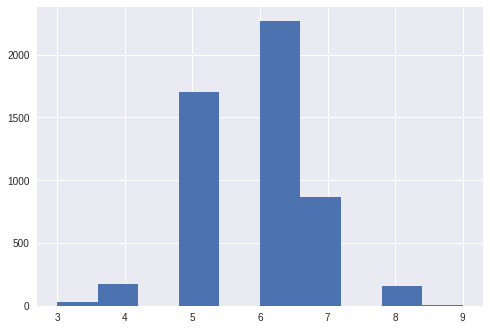

In [10]:
y_train.hist()
plt.show()

In [11]:
y_train.value_counts()

6    2267
5    1700
7     864
4     177
8     158
3      27
9       4
Name: quality, dtype: int64

Create one model for segment: Bad (<=4), 5, 6, 7, Good (>=8) 


In [12]:
split = ['<=4', '5', '6', '7', '>=8']

In [13]:
X_train.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,type_red
1226,0.447597,0.655613,-0.447790,-0.984101,-0.700266,-0.351688,-0.690870,-0.524047,0.607503,0.702322,0.069666,0
2980,0.678301,-0.681290,-0.282528,0.297431,-0.305943,-1.472748,-0.479096,0.057716,-1.511694,-1.312997,-0.092853,0
4741,1.454524,-0.067173,-0.282528,0.277715,0.372436,0.412294,0.320940,0.458932,-1.313019,0.789945,-0.417892,0
2759,-1.295404,-0.816770,-0.282528,-0.964385,-0.959515,-0.745751,-1.914456,-0.962041,1.667102,0.527077,0.394706,0
4792,-0.643065,0.148784,-0.723690,-0.447265,-1.018068,0.489629,-0.760632,-0.538685,-0.654936,0.128910,-0.490756,1


In [14]:
y_train.head()

1226    6
2980    5
4741    6
2759    6
4792    6
Name: quality, dtype: int64

In [15]:
train = pd.concat([X_train, y_train], axis=1)

In [16]:
train_split = {}
for name in split:
    temp = train['quality']
    if name == '<=4':
        train['quality'] = train.quality <= 4 
    elif name == '>=8':
        train['quality'] = train.quality >= 8
    else:
        train['quality'] = train.quality == int(name)
    train.quality.astype(int)
    train_split[name] = train.copy()
    train['quality'] = temp

In [17]:
def balanceData(train_split):
    for key in train_split:
        df = train_split[key]
        #df = df.sample(n=train.quality.value_counts().max(), replace=True)
        df_pos = df[df.quality == True]
        df_neg = df[df.quality == False]
        n = df_neg.shape[0]
        f = n//4
        df_pos = df_pos.sample(n=f, replace=True)
        df = pd.concat([df_neg, df_pos]).sample(frac=1)
        train_split[key] = df

balanceData(train_split)        

In [18]:
clfs = {}
for name in split:
    clf = LogisticRegression(penalty='l1', C=100, n_jobs=-1)
    #print(name)
    #print( train_split[name].head())
    #print()
    X_train = train_split[name].ix[:,:-1]
    y_train = train_split[name].quality
    clf.fit(X_train, y_train)
    clfs[name] = clf

In [19]:
# Merge back data
"""
We want to get back the initial training data set but with new features corresponding to
the predictions made by the classifiers restricted to each quality.
"""
new_data = pd.DataFrame([])
for name in split:
    new_data = pd.concat([new_data, train_split[name]])

In [24]:
# Make prediction
pred = pd.DataFrame(columns=['<=4', '5', '6', '7', '>=8'])
for i in range(X_test.shape[0]):
    current_pred = []
    for idx, name in enumerate(split):
        temp = clfs[name].predict_proba(X_test.iloc[i].values.reshape(1,-1))[0][1]
        #temp += 0.05
        current_pred.append(temp)
    current_pred = pd.DataFrame(pd.Series(current_pred).values.reshape(1,-1), index=[X_test.index[i]], columns=split)
    pred = pd.concat([pred, current_pred], axis=0)

In [25]:
# Now we have the predictions for each wine on each quality segment
# Let's try to figure out how to put together this info for a final prediction

In [ ]:
# Weighted prediction
new_col = []
for i in range(pred.shape[0]):
    l = len(split)
    x = np.array(pred.iloc[i][:l])
    temp = np.inner(x, np.array(range(4,9)))/np.sum(x)
    new_col.append(temp)  
pred.insert(pred.shape[1] - 1, 'weighted', new_col)

In [ ]:
# Max prediction
new_col = []
for i in range(pred.shape[0]):
    x = np.array(pred.iloc[i][:5]).argmax()
    new_col.append(x + 4)  
pred.insert(pred.shape[1] - 1, 'max', new_col)

In [ ]:
pred.head()

## Weighted

In [ ]:
print("MAE =", mean_absolute_error(y_test, pred['weighted'].apply(np.rint)))
print("Acc. =", accuracy_score(y_test, pred['weighted'].apply(np.rint)))

In [ ]:
confusion_matrix(y_test, pred['weighted'].apply(np.rint))

In [ ]:
pred['weighted'].apply(np.rint).value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
data.quality.value_counts()

## Max

In [ ]:
print("MAE =", mean_absolute_error(y_test, pred['max']))
print("Acc. =", accuracy_score(y_test, pred['max']))

In [ ]:
confusion_matrix(y_test, pred['max'].apply(np.rint))